Conectando a MongoDB...
INFO: Iniciando Extraccion
Log iniciado: logs/log_20251025_164531.txt
INFO: Conexión exitosa a MongoDB: mongodb://localhost:27017/
INFO: Base de datos: airbnb
Conectado exitosamente a MongoDB.
INICIANDO ANALISIS EXPLORATORIO DE DATOS (EDA) DE AIRBNB...
INICIANDO ANALISIS EXPLORATORIO COMPLETO
Usando muestreo inteligente basado en el tamano de cada coleccion

CARGANDO DATOS PARA ANALISIS...
Analizando tamaño de las colecciones...
INFO: Obteniendo estadísticas de colecciones
Obteniendo estadísticas de colecciones...
INFO: Colección 'reviews': 1388226 documentos
reviews: 1,388,226 documentos
INFO: Colección 'calendar': 9636365 documentos
calendar: 9,636,365 documentos
INFO: Colección 'listings': 26401 documentos
listings: 26,401 documentos

Extrayendo TODOS los datos disponibles...
   reviews: 1,388,226 docs -> Cargando TODOS los datos
   calendar: 9,636,365 docs -> Cargando TODOS los datos
   listings: 26,401 docs -> Cargando TODOS los datos
INFO: Extraídos 26401 

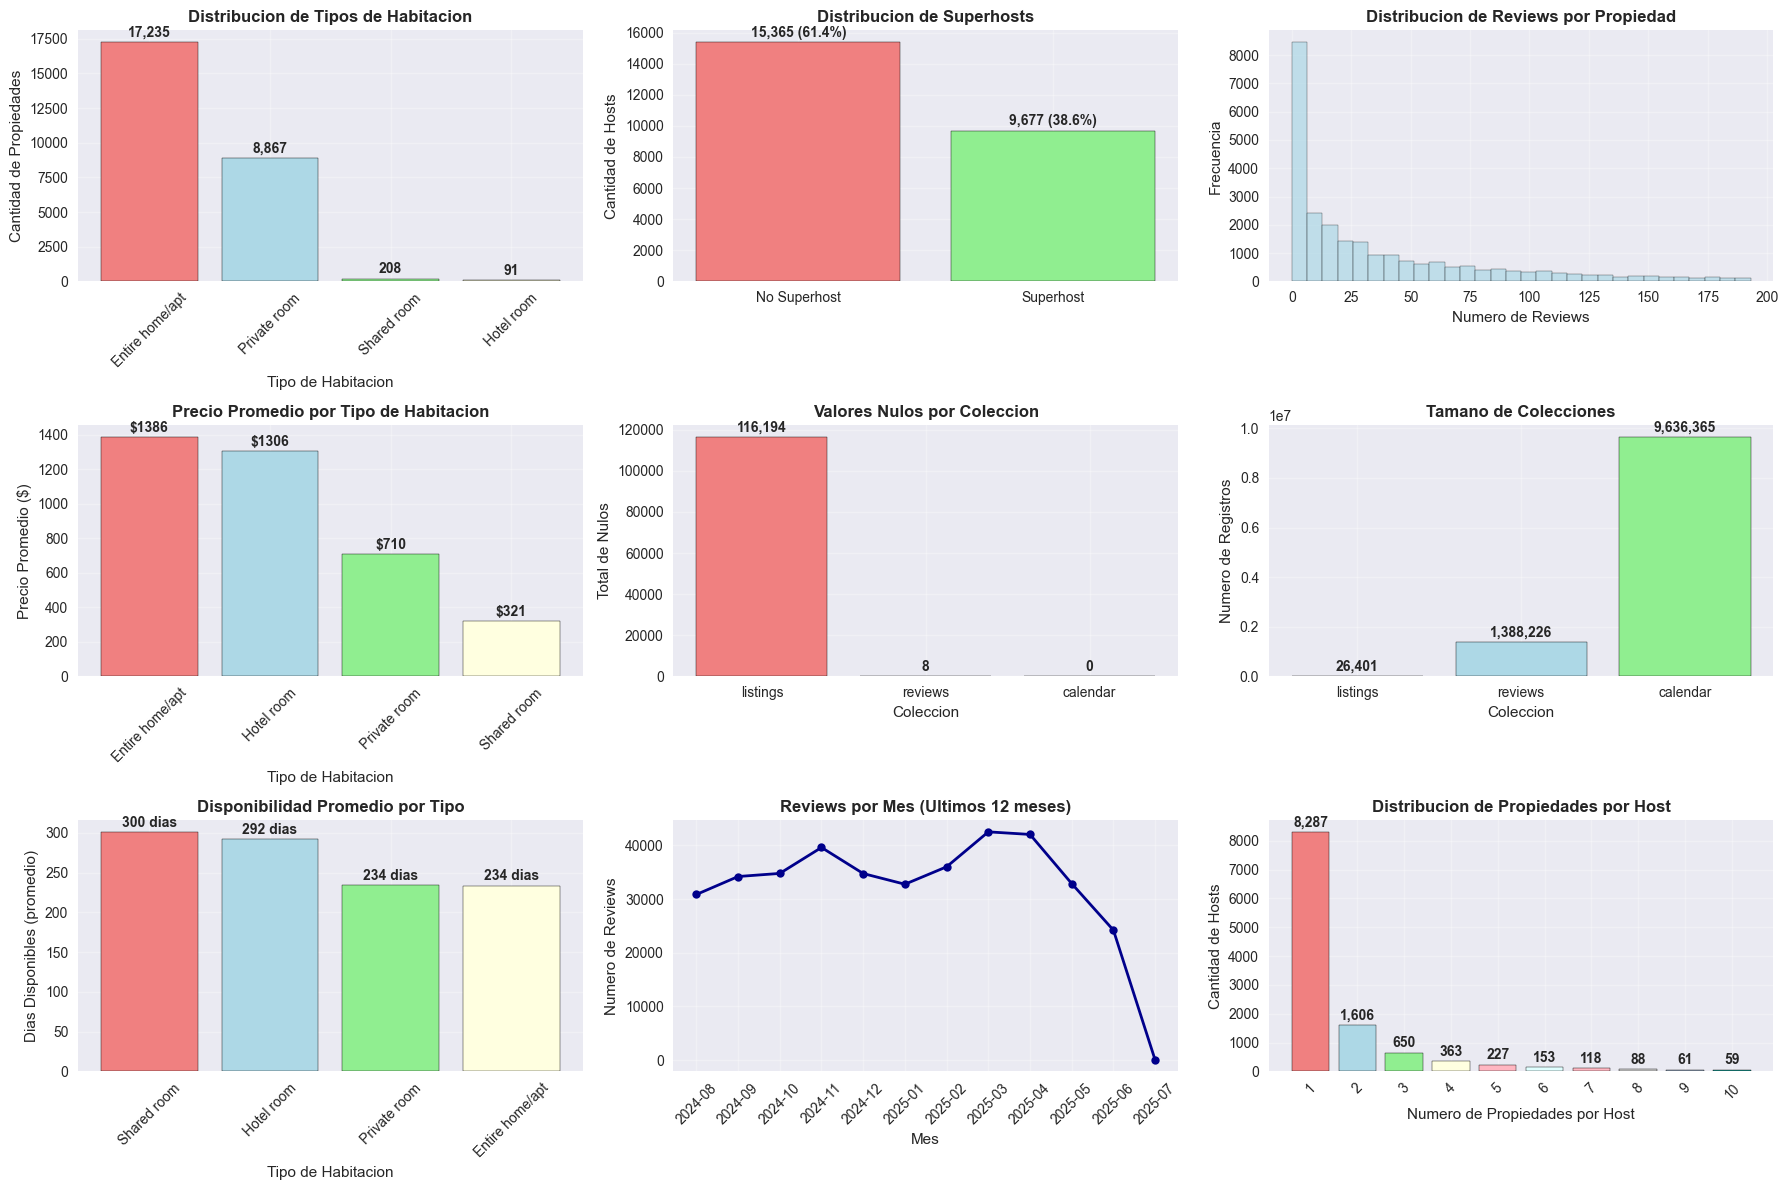

Visualizacion guardada: imagenes/analisis_airbnb_util.png

DOCUMENTACION DE HALLAZGOS
HALLAZGOS PRINCIPALES:
------------------------------
 1. Coleccion listings: 26,401 registros, 77 columnas
 2. Coleccion reviews: 1,388,226 registros, 7 columnas
 3. Coleccion calendar: 9,636,365 registros, 6 columnas
 4. Campo minimum_nights en listings: 13.1% de outliers
 5. Campo number_of_reviews en listings: 8.2% de outliers
 6. Campo minimum_nights en calendar: 6.8% de outliers
 7. Coleccion listings: Campos anidados encontrados: ['host_verifications']

RESUMEN ESTADISTICO:
------------------------------
- LISTINGS: 26,401 registros, 77 columnas
- REVIEWS: 1,388,226 registros, 7 columnas
- CALENDAR: 9,636,365 registros, 6 columnas

Hallazgos guardados en: hallazgos_eda_airbnb.json

ANALISIS EXPLORATORIO COMPLETADO EXITOSAMENTE!
INFO: Conexión a MongoDB cerrada
Conexión a MongoDB cerrada
INFO: Finalizando Extraccion
Log cerrado correctamente


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from typing import Dict, List, Tuple, Optional
import json
import os

# Importar seaborn de forma opcional
try:
    import seaborn as sns
    SEABORN_AVAILABLE = True
    # Configuración para visualizaciones
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
except ImportError:
    SEABORN_AVAILABLE = False
    print("AVISO: Seaborn no está disponible. Las visualizaciones usarán matplotlib básico.")

warnings.filterwarnings('ignore')

# Configuración de pandas para mostrar más información
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

class EDAAirbnbWindows:
    """
    Clase para realizar Análisis Exploratorio de Datos (EDA) de Airbnb.
    """
    
    def __init__(self, extractor):
        """
        Inicializa la clase EDA con un extractor de datos.
        
        Args:
            extractor: Instancia de la clase Extraccion para obtener datos
        """
        self.extractor = extractor
        self.datos = {}
        self.estadisticas_generales = {}
        self.hallazgos = []
        
        print("INICIANDO ANALISIS EXPLORATORIO DE DATOS (EDA) DE AIRBNB...")
    
    def cargar_datos_para_analisis(self, limite_por_coleccion: int = None, usar_muestreo_inteligente: bool = True):
        """
        Carga los datos de todas las colecciones para el análisis.
        
        Args:
            limite_por_coleccion (int, optional): Límite de registros por colección
            usar_muestreo_inteligente (bool): Si True, usa límites inteligentes basados en el tamaño de cada colección
        """
        print("\nCARGANDO DATOS PARA ANALISIS...")
        
        try:
            # Primero obtener estadísticas de las colecciones
            print("Analizando tamaño de las colecciones...")
            estadisticas = self.extractor.obtener_estadisticas_colecciones()
            
            # Extraer TODOS los datos disponibles (sin límites)
            print("\nExtrayendo TODOS los datos disponibles...")
            for coleccion, total_docs in estadisticas.items():
                print(f"   {coleccion}: {total_docs:,} docs -> Cargando TODOS los datos")
            
            self.datos['listings'] = self.extractor.obtener_listings()
            self.datos['reviews'] = self.extractor.obtener_reviews()
            self.datos['calendar'] = self.extractor.obtener_calendar()
            
            print(f"\nDATOS CARGADOS EXITOSAMENTE:")
            for nombre, df in self.datos.items():
                total_original = estadisticas.get(nombre, 0)
                porcentaje = (len(df) / total_original * 100) if total_original > 0 else 100
                print(f"   {nombre}: {len(df):,} registros ({porcentaje:.1f}% del total), {len(df.columns)} columnas")
                
        except Exception as e:
            print(f"ERROR al cargar datos: {e}")
            raise
    
    def analisis_general_datos(self):
        """
        Realiza análisis general de la estructura de los datos.
        """
        print("\n" + "="*60)
        print("ANALISIS GENERAL DE DATOS")
        print("="*60)
        
        analisis = {}
        
        for nombre_coleccion, df in self.datos.items():
            print(f"\nAnalizando coleccion: {nombre_coleccion.upper()}")
            print("-" * 40)
            
            # Información básica
            info_basica = {
                'registros': len(df),
                'columnas': len(df.columns),
                'memoria_mb': round(df.memory_usage(deep=True).sum() / 1024**2, 2)
            }
            
            print(f"Registros: {info_basica['registros']:,}")
            print(f"Columnas: {info_basica['columnas']}")
            print(f"Memoria: {info_basica['memoria_mb']} MB")
            
            # Mostrar primeras filas
            print(f"\nPrimeras 3 filas:")
            print(df.head(3).to_string())
            
            # Información de tipos de datos
            print(f"\nTipos de datos:")
            tipos_info = df.dtypes.value_counts()
            for tipo, cantidad in tipos_info.items():
                print(f"   {tipo}: {cantidad} columnas")
            
            # Columnas principales
            print(f"\nColumnas principales:")
            columnas_principales = df.columns.tolist()[:10]
            for i, col in enumerate(columnas_principales, 1):
                print(f"   {i:2d}. {col}")
            if len(df.columns) > 10:
                print(f"   ... y {len(df.columns) - 10} columnas más")
            
            analisis[nombre_coleccion] = {
                'info_basica': info_basica,
                'tipos_datos': df.dtypes.to_dict(),
                'columnas': df.columns.tolist()
            }
            
            # Guardar hallazgo
            self.hallazgos.append(f"Coleccion {nombre_coleccion}: {info_basica['registros']:,} registros, {info_basica['columnas']} columnas")
        
        self.estadisticas_generales = analisis
        return analisis
    
    def analisis_calidad_datos(self):
        """
        Analiza la calidad de los datos: nulos, duplicados y outliers.
        """
        print("\n" + "="*60)
        print("ANALISIS DE CALIDAD DE DATOS")
        print("="*60)
        
        calidad_analisis = {}
        
        for nombre_coleccion, df in self.datos.items():
            print(f"\nAnalizando calidad: {nombre_coleccion.upper()}")
            print("-" * 40)
            
            # Análisis de valores nulos
            print("Analisis de valores nulos:")
            nulos_por_columna = df.isnull().sum()
            porcentaje_nulos = (nulos_por_columna / len(df)) * 100
            
            columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0].sort_values(ascending=False)
            
            if len(columnas_con_nulos) > 0:
                print("   Columnas con valores nulos:")
                for col, nulos in columnas_con_nulos.head(10).items():
                    porcentaje = porcentaje_nulos[col]
                    print(f"   - {col}: {nulos:,} nulos ({porcentaje:.1f}%)")
            else:
                print("   OK: No hay valores nulos")
            
            # Análisis de duplicados
            print(f"\nAnalisis de duplicados:")
            try:
                # Primero intentar identificar columnas con listas o tipos no hasheables
                columnas_problemas = []
                for col in df.columns:
                    try:
                        # Intentar aplicar hash a una muestra de valores para detectar problemas
                        muestra = df[col].dropna().head(10)
                        for val in muestra:
                            hash(val)  # Intentar hacer hash del valor
                    except (TypeError, ValueError):
                        columnas_problemas.append(col)
                
                # Si hay columnas problemáticas, excluirlas del análisis de duplicados
                if columnas_problemas:
                    print(f"   Columnas con tipos no hasheables (listas/dicts): {columnas_problemas}")
                    columnas_validas = [col for col in df.columns if col not in columnas_problemas]
                    if len(columnas_validas) > 0:
                        duplicados = df[columnas_validas].duplicated().sum()
                    else:
                        print("   ERROR: Todas las columnas contienen tipos no hasheables")
                        duplicados = 0
                else:
                    duplicados = df.duplicated().sum()
                
                porcentaje_duplicados = (duplicados / len(df)) * 100
                print(f"   Duplicados: {duplicados:,} ({porcentaje_duplicados:.2f}%)")
                
                if duplicados > 0:
                    print("   ADVERTENCIA: Se recomienda revisar y posiblemente eliminar duplicados")
                    self.hallazgos.append(f"Coleccion {nombre_coleccion}: {duplicados:,} duplicados encontrados")
                    
            except Exception as e:
                print(f"   ERROR durante el analisis de duplicados: {e}")
                print("   Continuando con el siguiente analisis...")
                duplicados = 0
                porcentaje_duplicados = 0
            
            # Análisis de outliers para campos numéricos específicos
            print(f"\nAnalisis de outliers:")
            campos_numericos = ['price', 'minimum_nights', 'availability_365', 'number_of_reviews']
            campos_existentes = [col for col in campos_numericos if col in df.columns]
            
            for campo in campos_existentes:
                if df[campo].dtype in ['int64', 'float64']:
                    # Convertir a numérico si es posible
                    serie_numerica = pd.to_numeric(df[campo], errors='coerce')
                    
                    if not serie_numerica.isna().all():
                        Q1 = serie_numerica.quantile(0.25)
                        Q3 = serie_numerica.quantile(0.75)
                        IQR = Q3 - Q1
                        limite_inferior = Q1 - 1.5 * IQR
                        limite_superior = Q3 + 1.5 * IQR
                        
                        outliers = serie_numerica[(serie_numerica < limite_inferior) | (serie_numerica > limite_superior)]
                        porcentaje_outliers = (len(outliers) / len(serie_numerica.dropna())) * 100
                        
                        print(f"   - {campo}: {len(outliers):,} outliers ({porcentaje_outliers:.1f}%)")
                        print(f"     Rango normal: [{limite_inferior:.2f}, {limite_superior:.2f}]")
                        
                        if porcentaje_outliers > 5:
                            self.hallazgos.append(f"Campo {campo} en {nombre_coleccion}: {porcentaje_outliers:.1f}% de outliers")
            
            # Resumen de calidad
            calidad_resumen = {
                'total_registros': len(df),
                'columnas_con_nulos': len(columnas_con_nulos),
                'total_nulos': nulos_por_columna.sum(),
                'duplicados': duplicados,
                'porcentaje_duplicados': porcentaje_duplicados
            }
            
            calidad_analisis[nombre_coleccion] = calidad_resumen
        
        return calidad_analisis
    
    def analisis_transformaciones_potenciales(self):
        """
        Analiza transformaciones potenciales necesarias en los datos.
        """
        print("\n" + "="*60)
        print("ANALISIS DE TRANSFORMACIONES POTENCIALES")
        print("="*60)
        
        transformaciones = {}
        
        for nombre_coleccion, df in self.datos.items():
            print(f"\nAnalizando transformaciones: {nombre_coleccion.upper()}")
            print("-" * 40)
            
            # Verificar campos anidados
            print("Verificando campos anidados:")
            campos_anidados = []
            for col in df.columns:
                # Verificar si hay valores que parecen JSON o listas
                muestra_valores = df[col].dropna().head(10)
                for valor in muestra_valores:
                    if isinstance(valor, str) and ('[' in valor or '{' in valor):
                        campos_anidados.append(col)
                        break
            
            if campos_anidados:
                print(f"   Campos potencialmente anidados: {campos_anidados}")
                self.hallazgos.append(f"Coleccion {nombre_coleccion}: Campos anidados encontrados: {campos_anidados}")
            else:
                print("   OK: No se detectaron campos anidados")
            
            # Verificar campos de fecha
            print("\nVerificando campos de fecha:")
            campos_fecha = []
            for col in df.columns:
                if any(palabra in col.lower() for palabra in ['date', 'time', 'created', 'updated']):
                    campos_fecha.append(col)
            
            if campos_fecha:
                print(f"   Campos de fecha detectados: {campos_fecha}")
                for campo in campos_fecha:
                    if df[campo].dtype == 'object':
                        print(f"   - {campo}: Necesita conversión a datetime")
            else:
                print("   OK: No se detectaron campos de fecha")
            
            # Verificar campos de precio/moneda
            print("\nVerificando campos de precio:")
            campos_precio = []
            for col in df.columns:
                if any(palabra in col.lower() for palabra in ['price', 'cost', 'fee', 'rate']):
                    campos_precio.append(col)
            
            if campos_precio:
                print(f"   Campos de precio detectados: {campos_precio}")
                for campo in campos_precio:
                    if df[campo].dtype == 'object':
                        print(f"   - {campo}: Necesita limpieza y conversión numérica")
            else:
                print("   OK: No se detectaron campos de precio")
            
            # Verificar campos de texto que necesitan estandarización
            print("\nVerificando campos de texto:")
            campos_texto = df.select_dtypes(include=['object']).columns.tolist()
            campos_texto_importantes = [col for col in campos_texto if any(
                palabra in col.lower() for palabra in ['name', 'description', 'summary', 'title']
            )]
            
            if campos_texto_importantes:
                print(f"   Campos de texto importantes: {campos_texto_importantes}")
        
        return transformaciones
    
    def generar_visualizaciones(self):
        """
        Genera visualizaciones útiles para el análisis exploratorio.
        """
        print("\n" + "="*60)
        print("GENERANDO VISUALIZACIONES UTILES")
        print("="*60)
        
        # Crear directorio para imágenes si no existe
        if not os.path.exists('imagenes'):
            os.makedirs('imagenes')
        
        # Crear figura con análisis más útiles
        plt.figure(figsize=(18, 12))
        
        # Subplot 1: Tipos de habitación (más útil que distribución de precios)
        if 'listings' in self.datos and 'room_type' in self.datos['listings'].columns:
            plt.subplot(3, 3, 1)
            room_counts = self.datos['listings']['room_type'].value_counts()
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink']
            bars = plt.bar(range(len(room_counts)), room_counts.values, 
                          color=colors[:len(room_counts)], edgecolor='black')
            plt.title('Distribucion de Tipos de Habitacion', fontsize=12, fontweight='bold')
            plt.xlabel('Tipo de Habitacion')
            plt.ylabel('Cantidad de Propiedades')
            plt.xticks(range(len(room_counts)), room_counts.index, rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Agregar valores en las barras
            for bar, valor in zip(bars, room_counts.values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(room_counts.values)*0.01,
                        f'{valor:,}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 2: Análisis de superhosts (más útil que boxplot)
        if 'listings' in self.datos and 'host_is_superhost' in self.datos['listings'].columns:
            plt.subplot(3, 3, 2)
            superhost_counts = self.datos['listings']['host_is_superhost'].value_counts()
            colors = ['lightcoral', 'lightgreen']
            bars = plt.bar(['No Superhost', 'Superhost'], superhost_counts.values, 
                          color=colors, edgecolor='black')
            plt.title('Distribucion de Superhosts', fontsize=12, fontweight='bold')
            plt.ylabel('Cantidad de Hosts')
            plt.grid(True, alpha=0.3)
            
            # Agregar porcentajes
            total = superhost_counts.sum()
            for bar, valor in zip(bars, superhost_counts.values):
                porcentaje = (valor / total) * 100
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(superhost_counts.values)*0.01,
                        f'{valor:,} ({porcentaje:.1f}%)', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 3: Número de reviews por propiedad (más útil que disponibilidad)
        if 'listings' in self.datos and 'number_of_reviews' in self.datos['listings'].columns:
            plt.subplot(3, 3, 3)
            reviews_data = self.datos['listings']['number_of_reviews'].dropna()
            # Filtrar outliers extremos para mejor visualización
            Q1 = reviews_data.quantile(0.25)
            Q3 = reviews_data.quantile(0.75)
            IQR = Q3 - Q1
            limite_superior = Q3 + 2 * IQR
            reviews_filtrado = reviews_data[reviews_data <= limite_superior]
            
            plt.hist(reviews_filtrado, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
            plt.title('Distribucion de Reviews por Propiedad', fontsize=12, fontweight='bold')
            plt.xlabel('Numero de Reviews')
            plt.ylabel('Frecuencia')
            plt.grid(True, alpha=0.3)
        
        # Subplot 4: Análisis de precios por tipo de habitación (más útil)
        if 'listings' in self.datos and 'price' in self.datos['listings'].columns and 'room_type' in self.datos['listings'].columns:
            plt.subplot(3, 3, 4)
            # Limpiar datos de precio
            df_listings = self.datos['listings'].copy()
            df_listings['price_clean'] = pd.to_numeric(
                df_listings['price'].astype(str).str.replace('$', '').str.replace(',', ''), 
                errors='coerce'
            )
            
            # Filtrar precios válidos y outliers extremos
            precios_validos = df_listings['price_clean'].dropna()
            Q1 = precios_validos.quantile(0.25)
            Q3 = precios_validos.quantile(0.75)
            IQR = Q3 - Q1
            limite_superior = Q3 + 2 * IQR
            precios_filtrado = precios_validos[precios_validos <= limite_superior]
            
            # Agrupar por tipo de habitación
            df_filtrado = df_listings[df_listings['price_clean'] <= limite_superior]
            precios_por_tipo = df_filtrado.groupby('room_type')['price_clean'].mean().sort_values(ascending=False)
            
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink']
            bars = plt.bar(range(len(precios_por_tipo)), precios_por_tipo.values, 
                          color=colors[:len(precios_por_tipo)], edgecolor='black')
            plt.title('Precio Promedio por Tipo de Habitacion', fontsize=12, fontweight='bold')
            plt.xlabel('Tipo de Habitacion')
            plt.ylabel('Precio Promedio ($)')
            plt.xticks(range(len(precios_por_tipo)), precios_por_tipo.index, rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Agregar valores en las barras
            for bar, valor in zip(bars, precios_por_tipo.values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(precios_por_tipo.values)*0.01,
                        f'${valor:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 5: Análisis de nulos por colección
        plt.subplot(3, 3, 5)
        colecciones = list(self.datos.keys())
        nulos_por_coleccion = []
        for nombre in colecciones:
            nulos = self.datos[nombre].isnull().sum().sum()
            nulos_por_coleccion.append(nulos)
        
        colors = ['lightcoral', 'lightblue', 'lightgreen']
        bars = plt.bar(colecciones, nulos_por_coleccion, 
                     color=colors[:len(colecciones)], edgecolor='black')
        plt.title('Valores Nulos por Coleccion', fontsize=12, fontweight='bold')
        plt.xlabel('Coleccion')
        plt.ylabel('Total de Nulos')
        plt.grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, valor in zip(bars, nulos_por_coleccion):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(nulos_por_coleccion)*0.01,
                    f'{valor:,}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 6: Tamaño de colecciones
        plt.subplot(3, 3, 6)
        tamanos = [len(df) for df in self.datos.values()]
        bars = plt.bar(colecciones, tamanos, 
                     color=colors[:len(colecciones)], edgecolor='black')
        plt.title('Tamano de Colecciones', fontsize=12, fontweight='bold')
        plt.xlabel('Coleccion')
        plt.ylabel('Numero de Registros')
        plt.grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, valor in zip(bars, tamanos):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tamanos)*0.01,
                    f'{valor:,}', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 7: Análisis de disponibilidad por tipo de habitación (más útil que disponibilidad general)
        if 'listings' in self.datos and 'availability_365' in self.datos['listings'].columns and 'room_type' in self.datos['listings'].columns:
            plt.subplot(3, 3, 7)
            df_listings = self.datos['listings']
            disponibilidad_por_tipo = df_listings.groupby('room_type')['availability_365'].mean().sort_values(ascending=False)
            
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink']
            bars = plt.bar(range(len(disponibilidad_por_tipo)), disponibilidad_por_tipo.values, 
                          color=colors[:len(disponibilidad_por_tipo)], edgecolor='black')
            plt.title('Disponibilidad Promedio por Tipo', fontsize=12, fontweight='bold')
            plt.xlabel('Tipo de Habitacion')
            plt.ylabel('Dias Disponibles (promedio)')
            plt.xticks(range(len(disponibilidad_por_tipo)), disponibilidad_por_tipo.index, rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Agregar valores en las barras
            for bar, valor in zip(bars, disponibilidad_por_tipo.values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(disponibilidad_por_tipo.values)*0.01,
                        f'{valor:.0f} dias', ha='center', va='bottom', fontweight='bold')
        
        # Subplot 8: Análisis de reviews por mes (más útil)
        if 'reviews' in self.datos and 'date' in self.datos['reviews'].columns:
            plt.subplot(3, 3, 8)
            # Convertir fecha a datetime
            df_reviews = self.datos['reviews'].copy()
            df_reviews['date'] = pd.to_datetime(df_reviews['date'], errors='coerce')
            df_reviews = df_reviews.dropna(subset=['date'])
            
            # Agrupar por mes
            df_reviews['mes'] = df_reviews['date'].dt.to_period('M')
            reviews_por_mes = df_reviews['mes'].value_counts().sort_index()
            
            # Tomar solo los últimos 12 meses para mejor visualización
            if len(reviews_por_mes) > 12:
                reviews_por_mes = reviews_por_mes.tail(12)
            
            plt.plot(range(len(reviews_por_mes)), reviews_por_mes.values, 
                    marker='o', linewidth=2, markersize=6, color='darkblue')
            plt.title('Reviews por Mes (Ultimos 12 meses)', fontsize=12, fontweight='bold')
            plt.xlabel('Mes')
            plt.ylabel('Numero de Reviews')
            plt.xticks(range(len(reviews_por_mes)), [str(x) for x in reviews_por_mes.index], rotation=45)
            plt.grid(True, alpha=0.3)
        
        # Subplot 9: Análisis de propiedades por anfitrión (más útil)
        if 'listings' in self.datos and 'host_id' in self.datos['listings'].columns:
            plt.subplot(3, 3, 9)
            propiedades_por_host = self.datos['listings']['host_id'].value_counts()
            # Analizar distribución de propiedades por host
            distribucion = propiedades_por_host.value_counts().sort_index()
            
            # Tomar solo los primeros 10 valores para mejor visualización
            if len(distribucion) > 10:
                distribucion = distribucion.head(10)
            
            colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink', 
                     'lightcyan', 'lightpink', 'lightgray', 'lightsteelblue', 'lightseagreen']
            bars = plt.bar(range(len(distribucion)), distribucion.values, 
                          color=colors[:len(distribucion)], edgecolor='black')
            plt.title('Distribucion de Propiedades por Host', fontsize=12, fontweight='bold')
            plt.xlabel('Numero de Propiedades por Host')
            plt.ylabel('Cantidad de Hosts')
            plt.xticks(range(len(distribucion)), distribucion.index, rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Agregar valores en las barras
            for bar, valor in zip(bars, distribucion.values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(distribucion.values)*0.01,
                        f'{valor:,}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('imagenes/analisis_airbnb_util.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Visualizacion guardada: imagenes/analisis_airbnb_util.png")
    
    def documentar_hallazgos(self):
        """
        Documenta todos los hallazgos del análisis exploratorio.
        """
        print("\n" + "="*60)
        print("DOCUMENTACION DE HALLAZGOS")
        print("="*60)
        
        resumen_hallazgos = {
            'fecha_analisis': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'colecciones_analizadas': list(self.datos.keys()),
            'total_registros': sum(len(df) for df in self.datos.values()),
            'hallazgos_principales': self.hallazgos
        }
        
        print("HALLAZGOS PRINCIPALES:")
        print("-" * 30)
        
        for i, hallazgo in enumerate(self.hallazgos, 1):
            print(f"{i:2d}. {hallazgo}")
        
        print(f"\nRESUMEN ESTADISTICO:")
        print("-" * 30)
        for nombre, df in self.datos.items():
            print(f"- {nombre.upper()}: {len(df):,} registros, {len(df.columns)} columnas")
        
        # Guardar hallazgos en archivo
        with open('hallazgos_eda_airbnb.json', 'w', encoding='utf-8') as f:
            json.dump(resumen_hallazgos, f, indent=2, ensure_ascii=False)
        
        print(f"\nHallazgos guardados en: hallazgos_eda_airbnb.json")
        
        return resumen_hallazgos
    
    def ejecutar_analisis_completo(self, limite_por_coleccion: int = None, usar_muestreo_inteligente: bool = True):
        """
        Ejecuta el análisis exploratorio completo.
        
        Args:
            limite_por_coleccion (int, optional): Límite de registros por colección
            usar_muestreo_inteligente (bool): Si True, usa límites inteligentes basados en el tamaño de cada colección
        """
        print("INICIANDO ANALISIS EXPLORATORIO COMPLETO")
        print("=" * 60)
        
        if usar_muestreo_inteligente:
            print("Usando muestreo inteligente basado en el tamano de cada coleccion")
        else:
            print(f"Usando limite fijo: {limite_por_coleccion} registros por coleccion")
        
        try:
            # 1. Cargar datos con muestreo inteligente
            self.cargar_datos_para_analisis(limite_por_coleccion, usar_muestreo_inteligente)
            
            # 2. Análisis general
            self.analisis_general_datos()
            
            # 3. Análisis de calidad
            self.analisis_calidad_datos()
            
            # 4. Transformaciones potenciales
            self.analisis_transformaciones_potenciales()
            
            # 5. Generar visualizaciones
            self.generar_visualizaciones()
            
            # 6. Documentar hallazgos
            self.documentar_hallazgos()
            
            print("\nANALISIS EXPLORATORIO COMPLETADO EXITOSAMENTE!")
            print("=" * 60)
            
        except Exception as e:
            print(f"ERROR durante el analisis: {e}")
            raise


# Ejemplo de uso
if __name__ == "__main__":
    """
    Ejemplo de uso del análisis exploratorio de datos.
    """
    try:
        # Importar la clase Extraccion
        from extraccion import ExtraccionWindows
        
        # Crear instancia del extractor
        print("Conectando a MongoDB...")
        extractor = ExtraccionWindows()
        
        # Crear instancia del EDA
        eda = EDAAirbnbWindows(extractor)
        
        # Ejecutar análisis completo con muestreo inteligente
        eda.ejecutar_analisis_completo(usar_muestreo_inteligente=True)
        
        # Cerrar conexión
        extractor.cerrar_conexion()
        
    except Exception as e:
        print(f"ERROR durante el analisis: {e}")
        print("Asegurate de que MongoDB este ejecutandose y que los datos esten cargados.")
